In [1]:
%cd ..
%pip install -e .

/home/sandor/dtu/2021-22-spring/advanced_machine_learning/p-reg
Obtaining file:///home/sandor/dtu/2021-22-spring/advanced_machine_learning/p-reg
  Preparing metadata (setup.py) ... done
  Attempting uninstall: src
    Found existing installation: src 0.1.0
    Uninstalling src-0.1.0:
      Successfully uninstalled src-0.1.0
  Running setup.py develop for src
Note: you may need to restart the kernel to use updated packages.


In [1]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from src.models.gcn import GCN0
from src.models.gat import GAT
from src.models.gcn import GCN_fix_2layer

from src.models.train_model import train_with_loss
from src.models.train_model import random_splits

from src.models.reg import make_preg_loss
from src.models.reg import compute_a_hat
from src.models.reg import set_reg_mask

from src.models.evaluate_model import evaluate0
from src.models.evaluate_model import evaluate1

import torch

import torch.nn.functional as F
import torch_geometric.transforms as T

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=T.NormalizeFeatures())
data = dataset[0].to(device)

L_cls = lambda x, y: F.cross_entropy(x, y, reduction='sum')
L_preg = lambda x, y: - (x * torch.log(y)).sum()

A_hat = compute_a_hat(data)
mu = 1

loss_fn = make_preg_loss(L_cls, L_preg, mu, A_hat)

metrics = []
for model_name in ('gcn', 'gat'):
    for alpha in  [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]:
    # for num_training_nodes in  tqdm([20, 40, 60, 80, 100]):
        data = set_reg_mask(data, int(alpha*data.x.shape[0]))

        torch.manual_seed(1)
        random.seed(1)

        if model_name == 'gcn':
            model = model = GCN_fix_2layer().to(device)
        elif model_name == 'gat':
            model = GAT(dataset=dataset).to(device)

        model = train_with_loss(model, data, loss_fn, num_epochs=200)
        # gcn_model = train2(gcn_model, data)
        acc = evaluate0(model, data)
        # print(f'mu: {mu}, reg, Accuracy: {acc:.4f}')

        train_acc, val_acc, test_acc = evaluate1(model, data)
        metrics.append({'model': model_name, 'unmask preg ratio': alpha, 'train_acc': train_acc, 'val_acc': val_acc, 'test_acc': test_acc})
        print(metrics[-1])


{'model': 'gcn', 'unmask preg ratio': 0.1, 'train_acc': 1.0, 'val_acc': 0.79, 'test_acc': 0.816}
{'model': 'gcn', 'unmask preg ratio': 0.2, 'train_acc': 0.9928571428571429, 'val_acc': 0.802, 'test_acc': 0.822}
{'model': 'gcn', 'unmask preg ratio': 0.3, 'train_acc': 0.9928571428571429, 'val_acc': 0.804, 'test_acc': 0.817}
{'model': 'gcn', 'unmask preg ratio': 0.4, 'train_acc': 0.9928571428571429, 'val_acc': 0.81, 'test_acc': 0.816}
{'model': 'gcn', 'unmask preg ratio': 0.5, 'train_acc': 0.9928571428571429, 'val_acc': 0.804, 'test_acc': 0.817}
{'model': 'gcn', 'unmask preg ratio': 0.6, 'train_acc': 0.9928571428571429, 'val_acc': 0.804, 'test_acc': 0.82}
{'model': 'gcn', 'unmask preg ratio': 0.7, 'train_acc': 0.9928571428571429, 'val_acc': 0.772, 'test_acc': 0.802}
{'model': 'gcn', 'unmask preg ratio': 0.8, 'train_acc': 0.9571428571428572, 'val_acc': 0.538, 'test_acc': 0.534}
{'model': 'gcn', 'unmask preg ratio': 0.9, 'train_acc': 0.9357142857142857, 'val_acc': 0.472, 'test_acc': 0.473}
{

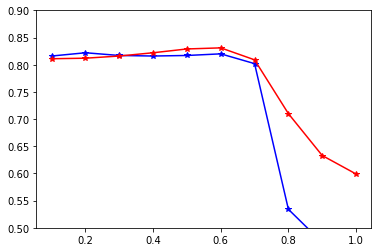

In [3]:
df = pd.DataFrame(metrics)
fig, ax = plt.subplots()

filt = (df['model'] == 'gcn')
ax.plot(df[filt]['unmask preg ratio'], df[filt]['test_acc'], '-*b')

filt = (df['model'] == 'gat')
ax.plot(df[filt]['unmask preg ratio'], df[filt]['test_acc'], '-*r')

ax.set(ylim=(.5, .9))
plt.show()